In [16]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [17]:
!gpustat

phoebe                         Sat Jun 18 22:27:41 2022  470.103.01
[0] NVIDIA GeForce GTX 1080 Ti | 21'C,   0 % |   791 / 11178 MB | s202357(787M)
[1] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     4 / 11178 MB |
[2] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     4 / 11178 MB |
[3] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     1 / 11178 MB |
[4] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     1 / 11178 MB |
[5] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[6] NVIDIA GeForce GTX 1080 Ti | 22'C,   0 % |     1 / 11178 MB |
[7] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |


In [18]:
os.environ['CUDA_VISIBLE_DEVICES']='2'


In [19]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [20]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [22]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [23]:
chart = [
[ ['05p', 'Blosum_ED', 20], ['1p', 'Blosum_ED', 20], ['25p', 'Blosum_ED', 20],  ['75p', 'Blosum_ED', 20], ['100p', 'Blosum_ED', 20]],
[ ['05p', 'EmbeddingAttention', 4], ['1p', 'EmbeddingAttention', 4],   ['25p', 'EmbeddingAttention', 4],  ['75p', 'EmbeddingAttention', 4], ['100p', 'EmbeddingAttention', 4]],
[ ['05p', 'EmbeddingAttention', 20], ['1p', 'EmbeddingAttention', 20],  ['25p', 'EmbeddingAttention', 20], ['75p', 'EmbeddingAttention', 20], ['100p', 'EmbeddingAttention', 20]],    
[ ['05p', 'EmbeddingAttention', 32], ['1p', 'EmbeddingAttention', 32],  ['25p', 'EmbeddingAttention', 32], ['75p', 'EmbeddingAttention', 32], ['100p', 'EmbeddingAttention', 32]],
[ ['05p', 'EmbeddingAttention', 64], ['1p', 'EmbeddingAttention', 64],  ['25p', 'EmbeddingAttention', 64], ['75p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 64]]
]

blosum_dict = {
'A' : [5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0],
'R' : [-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3],
'N' : [-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3],
'D' : [-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4],
'C' : [-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1],
'Q' : [-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3],
'E' : [-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3],
'G' : [0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4],
'H' : [-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4],
'I' : [-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4],
'L' : [-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1],
'K' : [-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3],
'M' : [-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1],
'F' : [-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1],
'P' : [-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3],
'S' : [1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2],
'T' : [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0],
'W' : [-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3],
'Y' : [-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1],
'V' : [0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5]
}

size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}

for key, val in zip(blosum_dict.keys(), blosum_dict.values()):
    if len(val) != 20:
        print(key +":"+ str(len(val)), end =", ")

In [24]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [25]:
pep_max_len = 14
hla_max_len = 34

tgt_len = pep_max_len + hla_max_len

d_ff = 512
n_layers, n_heads = 1, 3

batch_size = 1024
epochs = 25
threshold = 0.5

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'
id_emb = 'OF_TData_pad14_{}_{}'

save_attn = False
save_attn_hla = False


In [26]:
def list_to_df(l):
    df = pd.DataFrame(l, columns =['05p', '1p', '25p', '75p', '100p'], index=['Blosum-20', 'embd-4', 'embd-20','embd-32','embd-64'])
    return df

START TESTING

In [27]:
auc_list = []
auc01_list = []
ppv_list = []

In [28]:
for chart_idx_1 in range(len(chart)):

    auc_list_temp = []
    auc01_list_temp = []
    ppv_list_temp = []

    for chart_idx_2 in range(len(chart[chart_idx_1])):

        model_info = chart[chart_idx_1][chart_idx_2]
            
        if model_info == "model_info":#!= ['100p', 'EmbeddingAttention', 128]:
            continue
        else:

            print('\n\n\n')
            print(model_info)
            size = model_info[0] 
            
            
            if size == '1p':
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'
                id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'
            elif size == '05p':
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad_downsample0_125ep'
                id_emb = 'OF_TData_pad14_{}_{}_125ep_downsample0'
            else:
                id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'
                id_emb = 'OF_TData_pad14_{}_{}'


            model_type = model_info[1]
            d_model = d_k = d_v = model_info[2]

            print('===== Model Start - {}, {}, {} ====='.format(size,model_type,d_model))
            if "Blosum" in model_type:
                model_abbr = 'E'
                id_nested = id_blosum.format(size, model_type)  
                encoding_ = 'blosum'
                print("id:", id_nested)

                class EncoderLayer(nn.Module):
                    def __init__(self):
                        super(EncoderLayer, self).__init__()
                        self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                    def forward(self, enc_inputs, enc_self_attn_mask):
                        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                        return enc_outputs, attn


                class Encoder(nn.Module):
                    def __init__(self):
                        super(Encoder, self).__init__()
                        self.pos_emb = PositionalEncoding(d_model)
                        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                    def forward(self, enc_inputs, pep_to_pad):
                        #B# enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                        enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]

                        if pep_to_pad != []:
                            enc_self_attn_mask = fnc.get_attn_pad_mask(pep_to_pad, pep_to_pad) # [batch_size, src_len, src_len]
                        else:
                            enc_self_attn_mask = fnc.get_attn_pad_mask_fake(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]

                        enc_self_attns = []
                        for layer in self.layers:
                            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                            enc_self_attns.append(enc_self_attn)
                        return enc_outputs, enc_self_attns


                class DecoderLayer(nn.Module):
                    def __init__(self):
                        super(DecoderLayer, self).__init__()
                        self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                    def forward(self, dec_inputs, dec_self_attn_mask): 
                        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
                        dec_outputs = self.pos_ffn(dec_outputs)
                        return dec_outputs, dec_self_attn


                class Decoder(nn.Module):
                    def __init__(self):
                        super(Decoder, self).__init__()
                        self.use_cuda = use_cuda
                        device = torch.device('cuda')
                        self.pos_emb = PositionalEncoding(d_model)
                        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
                        self.tgt_len = tgt_len

                    def forward(self, dec_inputs): 
                        dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) # [batch_size, tgt_len, d_model]
                        dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)

                        dec_self_attns = []
                        for layer in self.layers:
                            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
                            dec_self_attns.append(dec_self_attn)

                        return dec_outputs, dec_self_attns


                class Transformer(nn.Module):
                    def __init__(self):
                        super(Transformer, self).__init__()
                        self.use_cuda = use_cuda
                        device = torch.device('cuda')
                        self.pep_encoder = Encoder().to(device)
                        self.hla_encoder = Encoder().to(device)
                        self.decoder = Decoder().to(device)
                        self.tgt_len = tgt_len
                        self.projection = nn.Sequential(
                                                        nn.Linear(tgt_len * d_model, 256),
                                                        nn.ReLU(True),

                                                        nn.BatchNorm1d(256),
                                                        nn.Linear(256, 64),
                                                        nn.ReLU(True),

                                                        nn.Linear(64, 2)
                                                        ).to(device)

                    def forward(self, pep_inputs, hla_inputs, pep_to_pad):
                        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs, pep_to_pad)
                        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs, [])
                        enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1)  
                        dec_outputs, dec_self_attns = self.decoder(enc_outputs)
                        dec_outputs = enc_outputs.view(enc_outputs.shape[0], -1) 

                        dec_logits = self.projection(dec_outputs) 

                        return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns

                print("Transformer Blosum imported")


            if "Embedding" in model_type:
                model_abbr = 'ED'
                id_nested = id_emb.format(size, model_type)
                encoding_ = 'embedding'

                class EncoderLayer(nn.Module):
                    def __init__(self):
                        super(EncoderLayer, self).__init__()
                        self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                    def forward(self, enc_inputs, enc_self_attn_mask):
                        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                        return enc_outputs, attn


                class Encoder(nn.Module):
                    def __init__(self):
                        super(Encoder, self).__init__()
                        self.src_emb = nn.Embedding(vocab_size, d_model)
                        self.pos_emb = PositionalEncoding(d_model)
                        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                    def forward(self, enc_inputs):
                        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                        enc_self_attn_mask = fnc.get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]

                        #print("\n\nshape enc_inputs-------")
                        #print("np.shape(enc_inputs)", np.shape(enc_inputs))
                        #for i in enc_inputs[0]:
                        #    print(i)

                        enc_self_attns = []
                        for layer in self.layers:
                            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                            enc_self_attns.append(enc_self_attn)
                        return enc_outputs, enc_self_attns
                print("Transformer Embedding imported")


                class DecoderLayer(nn.Module):
                    def __init__(self):
                        super(DecoderLayer, self).__init__()
                        self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                    def forward(self, dec_inputs, dec_self_attn_mask): 
                        '''
                        dec_inputs: [batch_size, tgt_len, d_model]
                        enc_outputs: [batch_size, src_len, d_model]
                        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
                        '''
                        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
                        dec_outputs = self.pos_ffn(dec_outputs) 
                        return dec_outputs, dec_self_attn


                class Decoder(nn.Module):
                    def __init__(self):
                        super(Decoder, self).__init__()
                        self.use_cuda = use_cuda
                        device = torch.device('cuda')
                        self.pos_emb = PositionalEncoding(d_model)
                        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
                        self.tgt_len = tgt_len

                    def forward(self, dec_inputs): 
                        '''
                        dec_inputs: [batch_size, tgt_len]
                        enc_intpus: [batch_size, src_len]
                        enc_outputs: [batsh_size, src_len, d_model]
                        '''
                        dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) 
                        dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)

                        dec_self_attns = []
                        for layer in self.layers:
                            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
                            dec_self_attns.append(dec_self_attn)

                        return dec_outputs, dec_self_attns


                class Transformer(nn.Module):
                        def __init__(self):
                            super(Transformer, self).__init__()
                            self.use_cuda = use_cuda
                            device = torch.device('cuda')
                            self.pep_encoder = Encoder().to(device)
                            self.hla_encoder = Encoder().to(device)
                            self.decoder = Decoder().to(device)
                            self.tgt_len = tgt_len
                            self.projection = nn.Sequential(
                                                            nn.Linear(tgt_len * d_model, 256),
                                                            nn.ReLU(True),

                                                            nn.BatchNorm1d(256),
                                                            nn.Linear(256, 64),
                                                            nn.ReLU(True),

                                                            #output layer
                                                            nn.Linear(64, 2)
                                                            ).to(device)

                        def forward(self, pep_inputs, hla_inputs):
                            '''
                            pep_inputs: [batch_size, pep_len]
                            hla_inputs: [batch_size, hla_len]
                            '''
                            pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
                            hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
                            enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1) # concat pep & hla embedding

                            dec_outputs, dec_self_attns = self.decoder(enc_outputs)
                            dec_outputs = dec_outputs.view(dec_outputs.shape[0], -1) # Flatten [batch_size, tgt_len * d_model]
                            dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

                            return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns, dec_self_attns







            ep_best = 0
            fold = 0

            test_fold_metrics_list_nested = []

            fold_avg_4 = True
            type_ = 'test'

            df_list = []
            time_testing = time.time()

            fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
            pred_all = []
            target_all = []
            enc_attn_list_all = []
            enc_hla_attn_list_all = []
            
            df_name = '/home/s202357/thesis/transmut/pipeline/procedure/test/perf/' + '{}_d{}_HLAperf.csv'.format(id_nested,d_model)
            print("Will be saved:", df_name)
            for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

                    pred_fold = []
                    target_fold = []
                    enc_attn_list_tmp = []
                    enc_hla_attn_list_tmp = []

                    for f in fold_avg:
                        index_order_idx = f
                        path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                        print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                        test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                            model_type, 
                                                                                                                            pep_max_len,
                                                                                                                            hla_max_len,
                                                                                                                            vocab,
                                                                                                                            index_order_idx, 
                                                                                                                            type_ = type_, 
                                                                                                                            fold = file_num,  
                                                                                                                            batch_size = batch_size)
                        model = Transformer().to(device)

                        model.load_state_dict(torch.load(path_saver))
                        model_test = model.eval()

                        if 'Blosum' in model_type:
                            ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test_bl(model_test, 
                                                                                                               model_abbr,
                                                                                                               threshold,
                                                                                                               test_loader, 
                                                                                                               fold, 
                                                                                                               ep_best, 
                                                                                                               epochs, 
                                                                                                               use_cuda)

                        else:
                            ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                               model_abbr,
                                                                                                               threshold,
                                                                                                               test_loader, 
                                                                                                               fold, 
                                                                                                               ep_best, 
                                                                                                               epochs, 
                                                                                                               use_cuda) # , test_res_attns
                        pred_fold.append(y_prob)
                        target_fold = [x.item() for x in test_labels]
                        print("\t\t\t\t roc:", roc_auc_score(target_fold, y_prob))
                        print("")

                        if save_attn:
                            enc_attn_list_tmp.append(enc_attn_list)
                        if save_attn_hla:
                            enc_hla_attn_list_tmp.append(enc_hla_attn_list)

                        del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                        gc.collect()
                        torch.cuda.empty_cache()


                    #print("\t\tTaking the average:")   
                    # get avg of attn
                    if save_attn:
                        enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                        enc_attn_list_all.extend(enc_attn_list_mean)
                        del enc_attn_list_tmp, enc_attn_list_mean
                        gc.collect()
                    if save_attn_hla:
                        enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                        enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            

                    arrays = [np.array(x) for x in pred_fold]
                    pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
                    pred_all.extend(pred_fold_avg)
                    target_all.extend(target_fold)
                    print("\t\t roc:", roc_auc_score(target_fold, pred_fold_avg))

                    test_data['target_'] = target_fold
                    test_data['pred_'] = pred_fold_avg
                    df_list.append(test_data)


            df_pd_nested_test_unique = pd.concat(df_list)

            del df_list
            del enc_attn_list_tmp
            del enc_hla_attn_list_tmp
            del enc_attn_list, enc_hla_attn_list
            gc.collect()
            torch.cuda.empty_cache()

            df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])
            print('\t===== Model End - {}, {}, {} ====='.format(size,model_type,d_model))
            print("\t== Stats:")
            auc_ = roc_auc_score(df_results['target'], df_results['pred'])
            print("\t  auc:", auc_)

            num_pos = len(df_results[df_results['target']==1])
            df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
            num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
            ppv = num_true_pos/num_pos
            auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
            print("\t  auc fpr 0.1:", auc_01)
            print("\t  ppv:", ppv)

            acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
            roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)

            auc_list_temp.append(auc_)
            auc01_list_temp.append(auc_01)
            ppv_list_temp.append(ppv)
            
            df = df_pd_nested_test_unique.reset_index(drop=True)
            HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))

            HLA_perf = []
            for HLA in HLA_list:
                temp = df[df['HLA']==HLA]
                auc_ = roc_auc_score(temp['target_'], temp['pred_'])

                num_pos = len(temp[temp['target_']==1])
                df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                ppv = num_true_pos/num_pos

                auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
                HLA_perf.append([HLA, auc_, auc_01, ppv])

            HLA_perf_df = pd.DataFrame(HLA_perf, columns = ['HLA', 'AUC', 'AUC01', 'PPV'])  
            HLA_perf_df.sort_values(by = ['HLA'])

            #df.to_csv('{}_d{}_perf.csv'.format(id_nested,d_model)) 
            HLA_perf_df.to_csv(df_name) 
            print("Saved:", df_name)

    auc_list.append(auc_list_temp)
    auc01_list.append(auc01_list_temp)
    ppv_list.append(ppv_list_temp)





['05p', 'Blosum_ED', 20]
===== Model Start - 05p, Blosum_ED, 20 =====
id: OF_TData_pad14_05p_Blosum_ED_hlac_pad_downsample0_125ep
Transformer Blosum imported
Will be saved: /home/s202357/thesis/transmut/pipeline/procedure/test/perf/OF_TData_pad14_05p_Blosum_ED_hlac_pad_downsample0_125ep_d20_HLAperf.csv
	OF_TData_pad14_05p_Blosum_ED_hlac_pad_downsample0_125ep_d20_layer1_multihead3_MODEL0.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
				 roc: 0.9373418442246954

	OF_TData_pad14_05p_Blosum_ED_hlac_pad_downsample0_125ep_d20_layer1_multihead3_MODEL1.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
				 roc: 0.9372436639431267

	OF_TData_pad14_05p_Blosum_ED_hlac_pad_downsample0_125ep_d20_layer1_multihead3_MODEL2.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
				 roc: 0.9372614752344435

	OF_TData_pad14_05p_Blosum_ED_hlac_pad_downsample0_125ep_d20_layer1_multihead3_MODEL3.pkl
	Test File ID 0 372896 torch.Size([372896, 14, 20])
				 roc: 0.9361739872392841

		 r

In [30]:
def list_to_df(l, column=['05p', '1p', '25p', '75p', '100p'],index =['Blosum-20', 'embd-4', 'embd-20','embd-32','embd-64']):
    df = pd.DataFrame(l, columns =column, index=index)
    return df

display(list_to_df(auc_list))

display(list_to_df(auc01_list))

display(list_to_df(ppv_list))

#Emb 64 is the best with 100% of data

,05p,1p,25p,75p,100p
Blosum-20,0.943644,0.956141,0.977631,0.980339,0.980901
embd-4,0.811233,0.863732,0.962880,0.970418,0.971932
embd-20,0.934305,0.949801,0.977340,0.980019,0.980775
embd-32,0.927238,0.946205,0.977233,0.980510,0.981042
embd-64,0.925009,0.943715,0.977076,0.980806,0.981455


,05p,1p,25p,75p,100p
Blosum-20,0.669915,0.731659,0.844002,0.861141,0.864996
embd-4,0.319561,0.405313,0.766049,0.805648,0.814616
embd-20,0.629515,0.701896,0.842565,0.860168,0.864119
embd-32,0.591485,0.681070,0.841969,0.863249,0.865631
embd-64,0.584237,0.668849,0.841866,0.864272,0.868389


,05p,1p,25p,75p,100p
Blosum-20,0.758847,0.792550,0.858074,0.868370,0.870795
embd-4,0.524242,0.601583,0.812104,0.834862,0.839977
embd-20,0.735418,0.775474,0.857306,0.867738,0.870283
embd-32,0.713932,0.764641,0.857166,0.869545,0.871204
embd-64,0.711874,0.760094,0.861524,0.869988,0.872872


In [29]:
def list_to_df(l, column=['05p', '1p', '25p', '75p', '100p'],index =['Blosum-20', 'embd-4', 'embd-20','embd-32','embd-64']):
    df = pd.DataFrame(l, columns =column, index=index)
    return df

display(list_to_df(auc_list))

display(list_to_df(auc01_list))

display(list_to_df(ppv_list))


,05p,1p,25p,75p,100p
Blosum-20,0.943644,0.956141,0.977631,0.980339,0.980901
embd-4,0.811233,0.863732,0.962880,0.970418,0.971932
embd-20,0.934305,0.949801,0.977340,0.980019,0.980775
embd-32,0.927238,0.946205,0.977233,0.980510,0.981042
embd-64,0.925009,0.943715,0.977076,0.980806,0.981455


,05p,1p,25p,75p,100p
Blosum-20,0.669915,0.731659,0.844002,0.861141,0.864996
embd-4,0.319561,0.405313,0.766049,0.805648,0.814616
embd-20,0.629515,0.701896,0.842565,0.860168,0.864119
embd-32,0.591485,0.681070,0.841969,0.863249,0.865631
embd-64,0.584237,0.668849,0.841866,0.864272,0.868389


,05p,1p,25p,75p,100p
Blosum-20,0.758847,0.792550,0.858074,0.868370,0.870795
embd-4,0.524242,0.601583,0.812104,0.834862,0.839977
embd-20,0.735418,0.775474,0.857306,0.867738,0.870283
embd-32,0.713932,0.764641,0.857166,0.869545,0.871204
embd-64,0.711874,0.760094,0.861524,0.869988,0.872872


In [14]:
# Scrape the printed output from May 21
auc_list_temp = []
auc01_list_temp = []
ppv_list_temp = []


file1 = open('Attentionbased.txt', 'r')
Lines = file1.readlines()

# Strips the newline character
for line in Lines:
    if '	  auc: ' in line: 
        auc_list_temp.append( float(line.replace('	  auc: ', '').replace('\n', '')))
    if '	  auc fpr 0.1: ' in line:
        auc01_list_temp.append( float(line.replace('	  auc fpr 0.1: ', '').replace('\n', '')))
    if '	  ppv: ' in line:
        ppv_list_temp.append( float(line.replace('	  ppv: ', '').replace('\n', '')))
        
        
auc_list = [ auc_list_temp[0:5], auc_list_temp[5:10], auc_list_temp[10:15], auc_list_temp[15:20], auc_list_temp[20:25]]
auc01_list = [ auc01_list_temp[0:5], auc01_list_temp[5:10], auc01_list_temp[10:15], auc01_list_temp[15:20], auc01_list_temp[20:25]]
ppv_list = [ ppv_list_temp[0:5], ppv_list_temp[5:10], ppv_list_temp[10:15], ppv_list_temp[15:20], ppv_list_temp[20:25]]

auc_list_temp = [ round(x, 4) for x in auc_list_temp ]
auc01_list_temp = [ round(x, 4) for x in auc01_list_temp ]
ppv_list_temp = [ round(x, 4) for x in ppv_list_temp ]

auc_list_r = [ auc_list_temp[0:5], auc_list_temp[5:10], auc_list_temp[10:15], auc_list_temp[15:20], auc_list_temp[20:25]]
auc01_list_r = [ auc01_list_temp[0:5], auc01_list_temp[5:10], auc01_list_temp[10:15], auc01_list_temp[15:20], auc01_list_temp[20:25]]
ppv_list_r = [ ppv_list_temp[0:5], ppv_list_temp[5:10], ppv_list_temp[10:15], ppv_list_temp[15:20], ppv_list_temp[20:25]]


display(list_to_df(auc_list))

display(list_to_df(auc01_list))

display(list_to_df(ppv_list))
    
print("---------------------")    

display(list_to_df(auc_list_r))

display(list_to_df(auc01_list_r))

display(list_to_df(ppv_list_r))
    

,05p,1p,25p,75p,100p
Blosum-20,0.943644,0.956141,0.977631,0.980339,0.980901
embd-4,0.811233,0.863732,0.962880,0.970418,0.971932
embd-20,0.934305,0.949801,0.977340,0.980019,0.980775
embd-32,0.927238,0.946205,0.977233,0.980510,0.981042
embd-64,0.925009,0.943715,0.977076,0.980806,0.981455


,05p,1p,25p,75p,100p
Blosum-20,0.669915,0.731659,0.844002,0.861141,0.864996
embd-4,0.319561,0.405313,0.766049,0.805648,0.814616
embd-20,0.629515,0.701896,0.842565,0.860168,0.864119
embd-32,0.591485,0.681070,0.841969,0.863249,0.865631
embd-64,0.584237,0.668849,0.841866,0.864272,0.868389


,05p,1p,25p,75p,100p
Blosum-20,0.758847,0.792550,0.858074,0.868370,0.870795
embd-4,0.524242,0.601583,0.812104,0.834862,0.839977
embd-20,0.735418,0.775474,0.857306,0.867738,0.870283
embd-32,0.713932,0.764641,0.857166,0.869545,0.871204
embd-64,0.711874,0.760094,0.861524,0.869988,0.872872


---------------------


,05p,1p,25p,75p,100p
Blosum-20,0.9436,0.9561,0.9776,0.9803,0.9809
embd-4,0.8112,0.8637,0.9629,0.9704,0.9719
embd-20,0.9343,0.9498,0.9773,0.9800,0.9808
embd-32,0.9272,0.9462,0.9772,0.9805,0.9810
embd-64,0.9250,0.9437,0.9771,0.9808,0.9815


,05p,1p,25p,75p,100p
Blosum-20,0.6699,0.7317,0.8440,0.8611,0.8650
embd-4,0.3196,0.4053,0.7660,0.8056,0.8146
embd-20,0.6295,0.7019,0.8426,0.8602,0.8641
embd-32,0.5915,0.6811,0.8420,0.8632,0.8656
embd-64,0.5842,0.6688,0.8419,0.8643,0.8684


,05p,1p,25p,75p,100p
Blosum-20,0.7588,0.7925,0.8581,0.8684,0.8708
embd-4,0.5242,0.6016,0.8121,0.8349,0.8400
embd-20,0.7354,0.7755,0.8573,0.8677,0.8703
embd-32,0.7139,0.7646,0.8572,0.8695,0.8712
embd-64,0.7119,0.7601,0.8615,0.8700,0.8729


## Peptide len spec perf

In [ ]:
df_bl['Type']= 'BLOSUM'

df_bl_per_len = []

for len_ in [8,9,10,11,12,13,14]:
    temp = df_bl[df_bl['length']==len_]
    HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))
    auc_ = roc_auc_score(temp['target_'], temp['pred_'])

    num_pos = len(temp[temp['target_']==1])
    df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
    ppv = num_true_pos/num_pos

    auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
    df_bl_per_len.append([len_, auc_, auc_01, ppv, 'BLOSUM'])

df_bl_len = pd.DataFrame(df_bl_per_len, columns=['Peptide Length', 'AUC', 'AUC01', 'PPV', 'Method'])

df_per_len = []

for len_ in [8,9,10,11,12,13,14]:
    temp = df[df_bl['length']==len_]
    HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))
    auc_ = roc_auc_score(temp['target_'], temp['pred_'])

    num_pos = len(temp[temp['target_']==1])
    df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
    ppv = num_true_pos/num_pos

    auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
    df_per_len.append([len_, auc_, auc_01, ppv, 'LE'])

df_len = pd.DataFrame(df_per_len, columns=['Peptide Length', 'AUC', 'AUC01', 'PPV', 'Method'])

concat = pd.concat([df_bl_len, df_len], axis=0)
concat

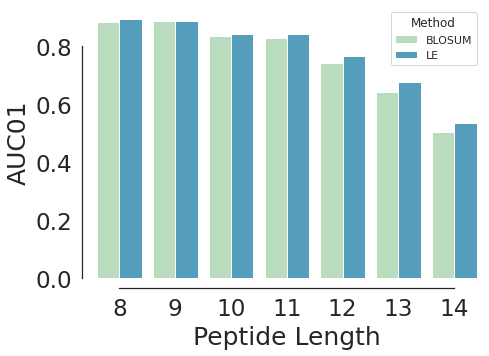

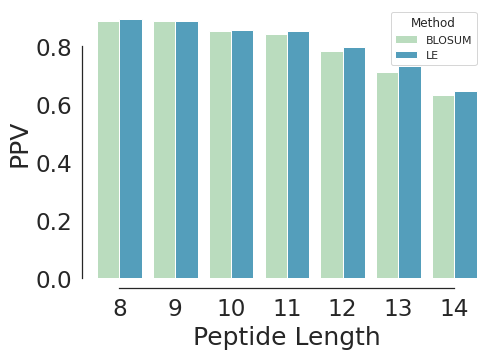

In [97]:
for metric in ['AUC01', 'PPV']:
    sn.set(rc = {'figure.figsize':(7,5)})

    sn.set(style='white')

    sn.barplot(x='Peptide Length', y=metric, hue='Method', data=concat, palette = 'GnBu')
    

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=25)

    for ax in plt.gcf().axes:
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=25)

    sn.set(font_scale=2.1)

    sn.despine(offset=10, trim=True)

    plt.show()